# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [ ]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [ ]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Chevallereau_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR3084371_sorted.bam,SRR3084369_sorted.bam,SRR3084378_sorted.bam,SRR3084370_sorted.bam,SRR3084368_sorted.bam,SRR3084374_sorted.bam,SRR3084376_sorted.bam,SRR3084367_sorted.bam,SRR3084375_sorted.bam,SRR3084372_sorted.bam,SRR3084373_sorted.bam,SRR3084377_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-Y880_01,CP020659.1,127,241,+,115,0,0,18954,0,0,276339,19907,0,1167222,0,1126595,13870
gene-Y880_02,CP020659.1,595,3669,-,3075,0,0,118,0,0,253,110,0,266,0,250,2
gene-Y880_03,CP020659.1,3666,5081,-,1416,0,0,44,0,0,33,21,0,60,0,25,0
gene-Y880_04,CP020659.1,5089,5760,-,672,0,0,14,0,0,37,7,0,51,0,22,0
gene-Y880_05,CP020659.1,5946,6542,+,597,0,0,22,0,0,22,16,0,67,0,38,0


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time_point
0,SRR3084367,RNA-Seq,75,398008413,PRJNA307603,SAMN04383803,261577106,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516047,GSM2027326,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:09:00Z,1,GSM2027326,Pseudomonas phage PAK P3,SRP068063,P3,3.5 min post infection
1,SRR3084368,RNA-Seq,75,39086550,PRJNA307603,SAMN04383804,26784815,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516048,GSM2027327,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:07:00Z,1,GSM2027327,Pseudomonas phage PAK P3,SRP068063,P3,3.5 min post infection
2,SRR3084369,RNA-Seq,75,372137270,PRJNA307603,SAMN04383805,254896423,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516049,GSM2027328,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:09:00Z,1,GSM2027328,Pseudomonas phage PAK P3,SRP068063,P3,3.5 min post infection
3,SRR3084370,RNA-Seq,75,920059126,PRJNA307603,SAMN04383806,593470588,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516050,GSM2027329,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:13:00Z,1,GSM2027329,Pseudomonas phage PAK P3,SRP068063,P3,13 min post infection
4,SRR3084371,RNA-Seq,75,62267893,PRJNA307603,SAMN04383807,41765045,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516051,GSM2027330,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:07:00Z,1,GSM2027330,Pseudomonas phage PAK P3,SRP068063,P3,13 min post infection
5,SRR3084372,RNA-Seq,75,1227135340,PRJNA307603,SAMN04383808,826467844,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516052,GSM2027331,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:14:00Z,1,GSM2027331,Pseudomonas phage PAK P3,SRP068063,P3,13 min post infection
6,SRR3084373,RNA-Seq,75,896761757,PRJNA307603,SAMN04383809,315768686,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516053,GSM2027332,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAK,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:10:00Z,1,GSM2027332,Pseudomonas aeruginosa PAK,SRP068063,PAK,0 min post infection
7,SRR3084374,RNA-Seq,75,946825478,PRJNA307603,SAMN04383810,324646971,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516054,GSM2027333,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAK,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:10:00Z,1,GSM2027333,Pseudomonas aeruginosa PAK,SRP068063,PAK,0 min post infection
8,SRR3084375,RNA-Seq,74,1069299612,PRJNA307603,SAMN04383811,739198296,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516056,GSM2027334,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAK,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:14:00Z,1,GSM2027334,Pseudomonas aeruginosa PAK,SRP068063,PAK,0 min post infection
9,SRR3084376,RNA-Seq,75,113486404,PRJNA307603,SAMN04383783,75812669,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516057,GSM2027335,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa PAK,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:08:00Z,1,GSM2027335,Pseudomonas aeruginosa PAK,SRP06

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM2027326': '3.5_phageR1', 'GSM2027327': '3.5_phageR2', 'GSM2027328': '3.5_phageR3',
              'GSM2027329': '13_phageR1', 'GSM2027330': '13_phageR2', 'GSM2027331': '13_phageR3',
              'GSM2027332': '0_hostR1', 'GSM2027333': '0_hostR2', 'GSM2027334': '0_hostR3',
              'GSM2027335': '13_hostR1', 'GSM2027336': '13_hostR2', 'GSM2027337': '13_hostR3',
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time_point
0,SRR3084367,RNA-Seq,75,398008413,PRJNA307603,SAMN04383803,261577106,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516047,GSM2027326,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:09:00Z,1,GSM2027326,Pseudomonas phage PAK P3,SRP068063,P3,3.5 min post infection


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time_point,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR3084367_sorted.bam,SRR3084367,RNA-Seq,75,398008413,PRJNA307603,SAMN04383803,261577106,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX1516047,GSM2027326,Illumina HiSeq 2000,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas phage PAK_P3,ILLUMINA,2016-07-25T00:00:00Z,2016-09-15T11:09:00Z,1,GSM2027326,Pseudomonas phage PAK P3,SRP068063,P3,3.5 min post infection,SRR3084367_sorted.bam,3.5_phageR1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_hostR1', '0_hostR2', '0_hostR3', '3.5_phageR1', '3.5_phageR2', '3.5_phageR3', 
         '13_hostR1', '13_hostR2', '13_hostR3', '13_phageR1', '13_phageR2', '13_phageR3']]
df

SampleNames,0_hostR1,0_hostR2,0_hostR3,3.5_phageR1,3.5_phageR2,3.5_phageR3,13_hostR1,13_hostR2,13_hostR3,13_phageR1,13_phageR2,13_phageR3
Geneid,,,,,,,,,,,,
gene-Y880_01,1126595,276339,1167222,0,0,0,19907,13870,18954,0,0,0
gene-Y880_02,250,253,266,0,0,0,110,2,118,0,0,0
gene-Y880_03,25,33,60,0,0,0,21,0,44,0,0,0
gene-Y880_04,22,37,51,0,0,0,7,0,14,0,0,0
gene-Y880_05,38,22,67,0,0,0,16,0,22,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PAK_P3sRNA2,0,0,0,19036,1553,12139,0,0,0,129747,8830,270264
gene-PAK_P3tRNA02,0,0,0,4867,424,3173,0,0,0,10336,852,17455
gene-PAK_P3as20,0,0,0,3518,428,3280,0,0,0,24144,2307,39160


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [14]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'U00096.3', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [16]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2
Geneid,,,,,,,,,,,,
gene-b0378,1329,1319,845,1007,784,1017,677,689,343,362,371,430
gene-b3128,132,155,81,109,61,106,82,79,50,67,40,136
gene-b3532,356,352,222,245,223,274,177,158,95,88,95,230
gene-b0048,2898,2687,2299,2794,2616,3219,2540,2668,812,954,585,682
gene-b3636,27774,28716,30977,36238,32205,40622,29255,33955,7819,9158,6019,6324
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1931,75,82,45,83,31,44,36,38,19,25,25,64
gene-b4312,584,701,415,641,278,355,281,306,136,157,256,334
gene-b3324,54,56,54,95,44,48,54,64,21,22,25,46


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [18]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [19]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

/ceph/ibmi/studenten/waffen/Data_NW/Guegler_2021/Notebook_T7/tools.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Geneid
gene-b0378      15.830752
gene-b3128       1.098982
gene-b3532       1.986420
gene-b0048      78.733472
gene-b3636    2155.580774
                 ...     
gene-b1931       1.471459
gene-b4312      12.638471
gene-b3324       0.870831
gene-b4842      24.668979
gene-b1107      50.508268
Length: 4544, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tpmData.iloc[:,i] = tpm
/ceph/ibmi/studenten/waffen/Data_NW/Guegler_2021/Notebook_T7/tools.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Geneid
gene-b0378      17.100398
gene-b3128       1.403747
gene-b3532       2.137737
gene-b0048      79.454440
gene-b3636    2425.678050
                 ...     
gene-b1931       

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0378,15.830752,17.100398,9.871778,9.705188,9.295160,11.154391,7.288468,6.969216,5.909978,4.929045,6.401725,5.744475,host,yaiW
gene-b3128,1.098982,1.403747,0.662828,0.734742,0.507575,0.813247,0.618219,0.559730,0.605218,0.639323,0.486133,1.268736,host,garD
gene-b3532,1.986420,2.137737,1.215654,1.106646,1.239195,1.408160,0.893560,0.749682,0.768884,0.563114,0.770087,1.439284,host,bcsB
gene-b0048,78.733472,79.454440,61.247456,61.409549,70.722489,80.514250,62.347502,61.530402,31.890061,29.607625,23.016429,20.775560,host,folA
gene-b3636,2155.580774,2425.678050,2357.398271,2275.275345,2487.131808,2902.571486,2051.347972,2236.993028,876.885559,811.678303,676.088307,550.057682,host,rpmG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1931,1.471459,1.750003,0.869523,1.316538,0.610889,0.798472,0.642699,0.636940,0.549138,0.567522,0.719228,1.408721,host,yedK
gene-b4312,12.638471,16.509020,8.809466,11.221538,5.992195,7.076978,5.499234,5.625705,4.264701,3.888948,8.026429,8.105319,host,fimB
gene-b3324,0.870831,0.982583,0.853891,1.234486,0.707535,0.713472,0.786769,0.874849,0.496388,0.410545,0.589661,0.832634,host,gspC


In [20]:
# Check gene names unique
len(tpms['Symbol'].unique())

4544

Log2+1 normalization tpms

In [21]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0378,4.073028,4.177949,3.442516,3.420238,3.363894,3.603406,3.051106,2.994438,2.788681,2.567800,2.887861,2.753706,host,yaiW
gene-b3128,1.069690,1.265285,0.733639,0.794721,0.592230,0.858576,0.694407,0.641296,0.682770,0.713100,0.571563,1.181889,host,garD
gene-b3532,1.578417,1.649724,1.147733,1.074948,1.162980,1.267931,0.921101,0.807093,0.822839,0.644423,0.823820,1.286458,host,bcsB
gene-b0048,6.317114,6.330100,5.959943,5.963695,6.164354,6.348980,5.985216,5.966486,5.039580,4.935819,4.585950,4.444638,host,folA
gene-b3636,11.074530,11.244767,11.203592,11.152459,11.280847,11.503613,11.003060,11.127990,9.777889,9.666541,9.403200,9.106060,host,rpmG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1931,1.305363,1.459433,0.902670,1.211970,0.687857,0.846771,0.716068,0.711001,0.631466,0.648486,0.781761,1.268267,host,yedK
gene-b4312,3.769610,4.130026,3.294175,3.611354,2.805745,3.013816,2.700270,2.728074,2.396352,2.289524,3.174155,3.186710,host,fimB
gene-b3324,0.903679,0.987381,0.890556,1.159943,0.771915,0.776923,0.837353,0.906775,0.581485,0.496253,0.668719,0.873919,host,gspC


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [22]:
columnOrder = ['0_R1', '0_R2', '2.5_R1', '2.5_R2', '5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2', '30_R1', '30_R2']

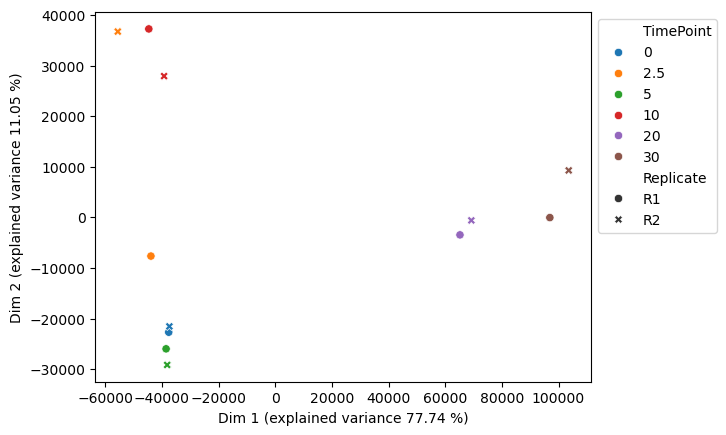

In [23]:
txPCA(tpms[columnOrder])

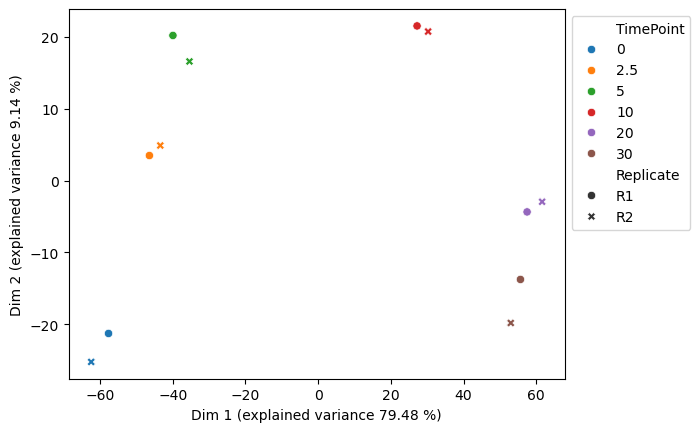

In [25]:
txPCA(logTPMs[columnOrder])

In [26]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

In [27]:
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0378,4.073028,4.177949,3.442516,3.420238,3.363894,3.603406,3.051106,2.994438,2.788681,2.567800,2.887861,2.753706,host,yaiW
gene-b3128,1.069690,1.265285,0.733639,0.794721,0.592230,0.858576,0.694407,0.641296,0.682770,0.713100,0.571563,1.181889,host,garD
gene-b3532,1.578417,1.649724,1.147733,1.074948,1.162980,1.267931,0.921101,0.807093,0.822839,0.644423,0.823820,1.286458,host,bcsB
gene-b0048,6.317114,6.330100,5.959943,5.963695,6.164354,6.348980,5.985216,5.966486,5.039580,4.935819,4.585950,4.444638,host,folA
gene-b3636,11.074530,11.244767,11.203592,11.152459,11.280847,11.503613,11.003060,11.127990,9.777889,9.666541,9.403200,9.106060,host,rpmG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1931,1.305363,1.459433,0.902670,1.211970,0.687857,0.846771,0.716068,0.711001,0.631466,0.648486,0.781761,1.268267,host,yedK
gene-b4312,3.769610,4.130026,3.294175,3.611354,2.805745,3.013816,2.700270,2.728074,2.396352,2.289524,3.174155,3.186710,host,fimB
gene-b3324,0.903679,0.987381,0.890556,1.159943,0.771915,0.776923,0.837353,0.906775,0.581485,0.496253,0.668719,0.873919,host,gspC


tpmHost

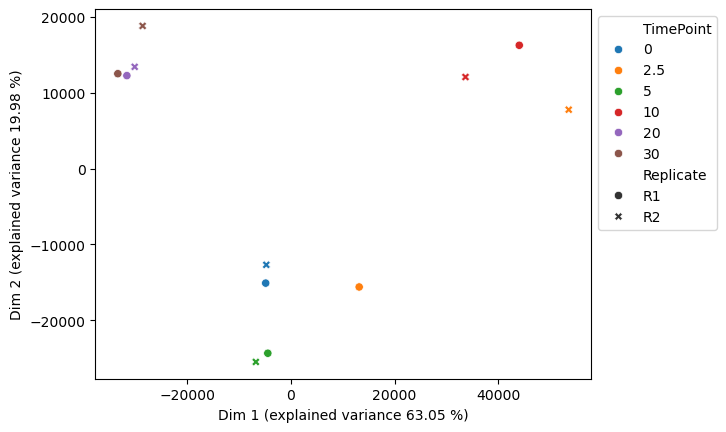

In [28]:
txPCA(tpmHost[columnOrder])

tpmPhage

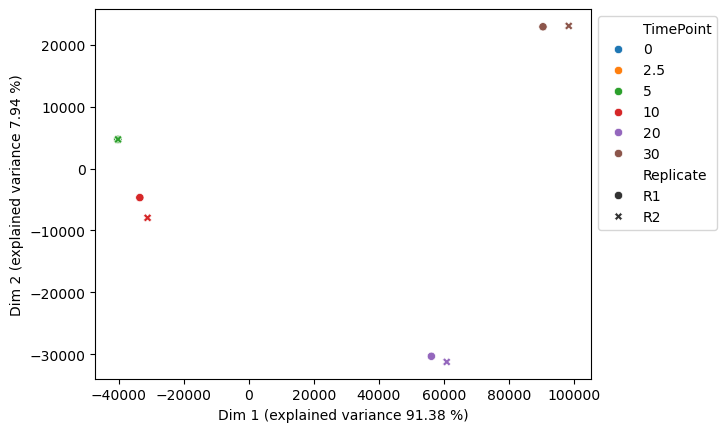

In [29]:
txPCA(tpmPhage[columnOrder])

logTPM Host

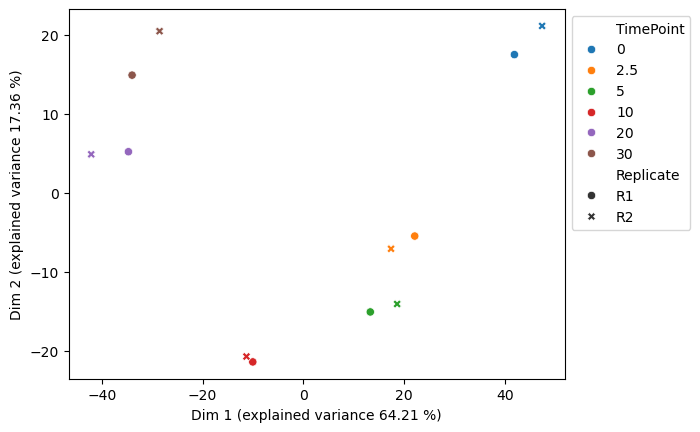

In [30]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

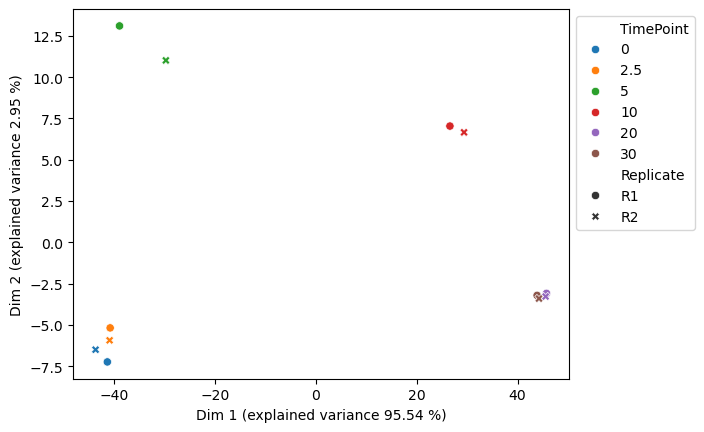

In [31]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates seem to be fine, especially when log transformed. TPM duplicates at T = 2.5 bit off, but since we only have two replicates, we couldnt decide which replicate to remove in theory. Additionally, logTPMs look fine. 

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [32]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '2.5', '5', '10', '20', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

/ceph/ibmi/studenten/waffen/Data_NW/Guegler_2021/Notebook_T7/tools.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  means[mean] = np.mean(df.iloc[:,indices], axis = 1)
/ceph/ibmi/studenten/waffen/Data_NW/Guegler_2021/Notebook_T7/tools.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sds[sd] = np.std(df.iloc[:,indices], axis = 1)
/ceph/ibmi/studenten/waffen/Data_NW/Guegler_2021/Notebook_T7/tools.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0378,16.465575,9.788483,10.224775,7.128842,5.419511,6.073100,host,yaiW
gene-b3128,1.251365,0.698785,0.660411,0.588974,0.622270,0.877435,host,garD
gene-b3532,2.062078,1.161150,1.323678,0.821621,0.665999,1.104685,host,bcsB
gene-b0048,79.093956,61.328502,75.618370,61.938952,30.748843,21.895995,host,folA
gene-b3636,2290.629412,2316.336808,2694.851647,2144.170500,844.281931,613.072994,host,rpmG
...,...,...,...,...,...,...,...,...
gene-b1931,1.610731,1.093031,0.704680,0.639820,0.558330,1.063974,host,yedK
gene-b4312,14.573746,10.015502,6.534586,5.562469,4.076824,8.065874,host,fimB
gene-b3324,0.926707,1.044188,0.710504,0.830809,0.453467,0.711147,host,gspC


In [33]:
TPMsds = TPMsds[['0', '2.5', '5', '10', '20', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0378,0.634823,0.083295,0.929615,0.159626,0.490466,0.328625,host,yaiW
gene-b3128,0.152382,0.035957,0.152836,0.029245,0.017052,0.391302,host,garD
gene-b3532,0.075658,0.054504,0.084482,0.071939,0.102885,0.334598,host,bcsB
gene-b0048,0.360484,0.081046,4.895880,0.408550,1.141218,1.120435,host,folA
gene-b3636,135.048638,41.061463,207.719839,92.822528,32.603628,63.015312,host,rpmG
...,...,...,...,...,...,...,...,...
gene-b1931,0.139272,0.223507,0.093791,0.002880,0.009192,0.344747,host,yedK
gene-b4312,1.935275,1.206036,0.542392,0.063236,0.187876,0.039445,host,fimB
gene-b3324,0.055876,0.190298,0.002969,0.044040,0.042921,0.121487,host,gspC


In [34]:
propExp = proportionalExp(TPMmeans[['0', '2.5', '5', '10', '20', '30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0378,1.000000,0.594482,0.620979,0.432954,0.329142,0.368836,host,yaiW
gene-b3128,1.000000,0.558418,0.527753,0.470666,0.497274,0.701182,host,garD
gene-b3532,1.000000,0.563097,0.641914,0.398443,0.322975,0.535715,host,bcsB
gene-b0048,1.000000,0.775388,0.956058,0.783106,0.388763,0.276835,host,folA
gene-b3636,0.850002,0.859541,1.000000,0.795654,0.313294,0.227498,host,rpmG
...,...,...,...,...,...,...,...,...
gene-b1931,1.000000,0.678593,0.437491,0.397223,0.346632,0.660554,host,yedK
gene-b4312,1.000000,0.687229,0.448381,0.381677,0.279738,0.553452,host,fimB
gene-b3324,0.887490,1.000000,0.680436,0.795651,0.434277,0.681053,host,gspC


## 5. Phage gene classification

Early, Middle, Late genes of T4 phage were classified based on peak expression at 2.5/5, 10, and 20/30 min. Paper states for T7 phage, analysis was performed similar.

In [35]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [36]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [37]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [38]:
TPMmeans

,0,2.5,5,10,20,30,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,
gene-b0378,16.465575,9.788483,10.224775,7.128842,5.419511,6.073100,host,yaiW,None,None
gene-b3128,1.251365,0.698785,0.660411,0.588974,0.622270,0.877435,host,garD,None,None
gene-b3532,2.062078,1.161150,1.323678,0.821621,0.665999,1.104685,host,bcsB,None,None
gene-b0048,79.093956,61.328502,75.618370,61.938952,30.748843,21.895995,host,folA,None,None
gene-b3636,2290.629412,2316.336808,2694.851647,2144.170500,844.281931,613.072994,host,rpmG,None,None
...,...,...,...,...,...,...,...,...,...,...
gene-b1931,1.610731,1.093031,0.704680,0.639820,0.558330,1.063974,host,yedK,None,None
gene-b4312,14.573746,10.015502,6.534586,5.562469,4.076824,8.065874,host,fimB,None,None
gene-b3324,0.926707,1.044188,0.710504,0.830809,0.453467,0.711147,host,gspC,None,None


In [44]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      53
middle     7
Name: count, dtype: int64

Add classes to other dfs.

In [46]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

## 6. Add variance to all dataframes

Base variance call on tpms.

In [47]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [48]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,
gene-b0378,15.830752,17.100398,9.871778,9.705188,9.295160,11.154391,7.288468,6.969216,5.909978,4.929045,6.401725,5.744475,host,yaiW,None,None,1.527957
gene-b3128,1.098982,1.403747,0.662828,0.734742,0.507575,0.813247,0.618219,0.559730,0.605218,0.639323,0.486133,1.268736,host,garD,None,None,0.109809
gene-b3532,1.986420,2.137737,1.215654,1.106646,1.239195,1.408160,0.893560,0.749682,0.768884,0.563114,0.770087,1.439284,host,bcsB,None,None,0.187742
gene-b0048,78.733472,79.454440,61.247456,61.409549,70.722489,80.514250,62.347502,61.530402,31.890061,29.607625,23.016429,20.775560,host,folA,None,None,8.482715
gene-b3636,2155.580774,2425.678050,2357.398271,2275.275345,2487.131808,2902.571486,2051.347972,2236.993028,876.885559,811.678303,676.088307,550.057682,host,rpmG,None,None,350.687679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b1931,1.471459,1.750003,0.869523,1.316538,0.610889,0.798472,0.642699,0.636940,0.549138,0.567522,0.719228,1.408721,host,yedK,None,None,0.172251
gene-b4312,12.638471,16.509020,8.809466,11.221538,5.992195,7.076978,5.499234,5.625705,4.264701,3.888948,8.026429,8.105319,host,fimB,None,None,1.560166
gene-b3324,0.870831,0.982583,0.853891,1.234486,0.707535,0.713472,0.786769,0.874849,0.496388,0.410545,0.589661,0.832634,host,gspC,None,None,0.057299


In [49]:
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [50]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [51]:
# Full TPM table
tpms.to_csv('Guegler_T7_minusToxIN_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Guegler_T7_minusToxIN_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Guegler_T7_minusToxIN_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Guegler_T7_minusToxIN_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Guegler_T7_minusToxIN_fractional_expression.tsv', sep = '\t')